## 機械学習：野球のスイング判定

* 野球のバッティングフォームを対象とする
* 良いスイングのパターンを学習させて判定できるようにしたい

### 今回用いる方法（概要）

1. 姿勢推定により身体の部位の位置を取得
2. 動画からスイング部分を切り出す（本Notebook内では取り扱わない）
3. 時系列に位置を並べてデータ化する
4. 良いパターンと良くないパターンについて学習する

### 準備：動画の処理（再生）

* OpenCV.VideoCapture
* 1フレームずつ表示

In [1]:
import time
import math
import numpy as np
import pandas as pd
import copy
import cv2
import matplotlib.pyplot as plt

from IPython.display import display, Image, clear_output
from pprint import pprint as pp

In [2]:
def imshow(img, width=240):
    _, buf = cv2.imencode(".jpg", img)
    display(Image(data=buf.tobytes(), width=width))
    clear_output(wait=True)

class CvCapture():
    def __init__(self, video_path):
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

    def read(self):
        return self.cap.read()
    
    def get_specified_frame(self, frame_number):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
        ret, frame = self.cap.read()
        return frame

    def release(self):
        self.cap.release()

    def process_frames(self, frame_proc=lambda x: x, target_frames=None, show_frames=True):
        frame_no = 0
        while True:
            st = time.time()
            ret, frame = self.cap.read()
            frame_no += 1
            if not ret:
                break
            elif target_frames is not None and frame_no not in target_frames:
                continue
            else:
                frame = frame_proc(frame)
            
            if show_frames:
                imshow(frame)
            else:
                print('processing', frame_no)
            
            elapsed_time = time.time() - st
            if elapsed_time < 1 / self.fps:
                time.sleep(1 /self.fps - elapsed_time)
    
        self.release()

In [3]:
# 今回使う動画
sample = 'data/sample_0.mp4'

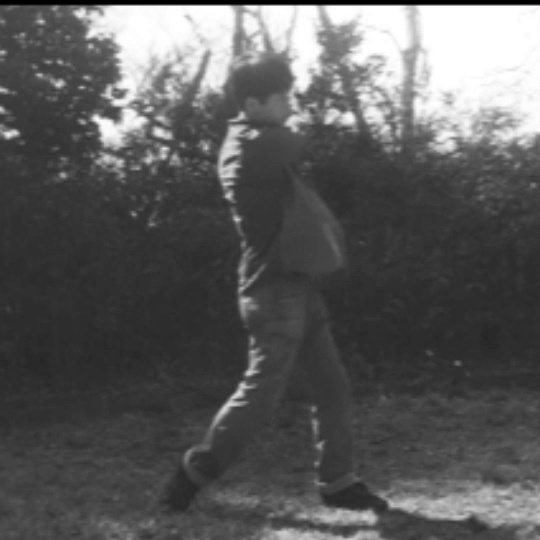

In [4]:
# 試しに再生
CvCapture(sample).process_frames()

### 1. 姿勢推定により身体の部位の位置を取得

1. **姿勢推定により身体の部位の位置を取得**
2. 動画からスイング部分を切り出す（本Notebook内では取り扱わない）
3. 時系列に位置を並べてデータ化する
4. 良いパターンと良くないパターンについて学習する

OpenPoseソースを取得する

In [6]:
# !git clone https://github.com/Hzzone/pytorch-openpose.git

Cloning into 'pytorch-openpose'...


OpenPoseに必要なライブラリのインストール

In [8]:
# !cd pytorch-openpose & pip install -r requirements.txt

姿勢推定モデルのダウンロード

In [9]:
# !wget https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABaYNMvvNVFRWqyDXl7KQUxa/body_pose_model.pth?dl=0 -p pytorch-openpose/model

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


Python実行時のパスを通す

In [10]:
import os, sys

# Pythonのインポートパスにopenposeを追加
openpose_path = 'pytorch-openpose'
sys.path.append(openpose_path)

print(sys.path)

['C:\\workspace\\pg\\form-analysis-sample', 'C:\\dev\\anaconda3\\envs\\torch39\\python39.zip', 'C:\\dev\\anaconda3\\envs\\torch39\\DLLs', 'C:\\dev\\anaconda3\\envs\\torch39\\lib', 'C:\\dev\\anaconda3\\envs\\torch39', '', 'C:\\dev\\anaconda3\\envs\\torch39\\lib\\site-packages', 'C:\\dev\\anaconda3\\envs\\torch39\\lib\\site-packages\\win32', 'C:\\dev\\anaconda3\\envs\\torch39\\lib\\site-packages\\win32\\lib', 'C:\\dev\\anaconda3\\envs\\torch39\\lib\\site-packages\\Pythonwin', 'pytorch-openpose']


In [11]:
from src import model
from src import util as op_util
from src.body import Body

__body_estimate = Body('pytorch-openpose/model/body_pose_model.pth')

def body_estimation(img):
    c, s = __body_estimate(img)
    return np.array(c), np.array(s)

C:\dev\anaconda3\envs\torch39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OpenPose-Pythonライブラリから提供された`Body`クラスに姿勢推定モデルを渡して初期化する。  
`Body`を実行すると指定した画像の人物およびその姿勢情報を推定して返却する。  
ここでは使いやすくするため、この処理を`body_estimation`関数として定義し、以降こちらを使用して画像の姿勢推定を行う。

**姿勢推定データを見る**

例として、動画データの30フレーム目の姿勢推定結果を表示する。

In [12]:
# 30フレーム目を取り出す
frame = CvCapture(sample).get_specified_frame(30)
# 姿勢推定
candidate, subset = body_estimation(frame)
print('Candidate サイズ', candidate.shape)
pp(candidate)
print('Subset サイズ', subset.shape)
pp(subset)

Candidate サイズ (18, 4)
array([[1.53000000e+02, 1.26000000e+02, 9.25101221e-01, 0.00000000e+00],
       [1.83000000e+02, 1.63000000e+02, 8.06242764e-01, 1.00000000e+00],
       [1.69000000e+02, 1.63000000e+02, 6.95913792e-01, 2.00000000e+00],
       [1.46000000e+02, 2.03000000e+02, 3.42946500e-01, 3.00000000e+00],
       [1.21000000e+02, 1.82000000e+02, 4.03699368e-01, 4.00000000e+00],
       [1.97000000e+02, 1.62000000e+02, 8.91960144e-01, 5.00000000e+00],
       [1.48000000e+02, 1.96000000e+02, 6.23045504e-01, 6.00000000e+00],
       [1.14000000e+02, 1.83000000e+02, 3.88996780e-01, 7.00000000e+00],
       [1.87000000e+02, 2.96000000e+02, 7.75201082e-01, 8.00000000e+00],
       [1.74000000e+02, 3.94000000e+02, 9.15523469e-01, 9.00000000e+00],
       [1.88000000e+02, 4.77000000e+02, 8.49171996e-01, 1.00000000e+01],
       [2.25000000e+02, 2.92000000e+02, 8.20244253e-01, 1.10000000e+01],
       [2.50000000e+02, 3.84000000e+02, 9.04083967e-01, 1.20000000e+01],
       [3.07000000e+02, 4.690

**部位データ**

OpenPoseの姿勢推定結果には`Candidate`と`Subset`があり、`body_estimation`関数から実行結果として返却される。

Candidate
* 身体部位の検出情報
* サイズは検出された個体数×18（各個体は18個の部位データがある）
* 部位データは`[X座標, Y座標, 確度, 検出ID]`
* 複数人物が居る画像では複数の部位データがあり、その場合、検出IDが順序通りの数になるとは限らない

Subset
* 個体の検出情報
* サイズは検出された人物等の個体数（各個体には18個の検出IDとスコア）
* 検出IDは検出された場合のみ0以上の整数、検出されなければ-1が入る
* SubsetのN番目のデータはCandidateのN番目のデータに対応する

以降ではこれを**部位データ**と記述する。

**部位データを元画像に描画する処理**

CandidateとSubsetで指定された部位を繋げて骨格のように表示する。
描画処理のソースコードは別ファイルに記載。

In [13]:
def draw_bodypose(img, candidate, subset):
    return op_util.draw_bodypose(copy.deepcopy(img), candidate, subset)

試しに実行

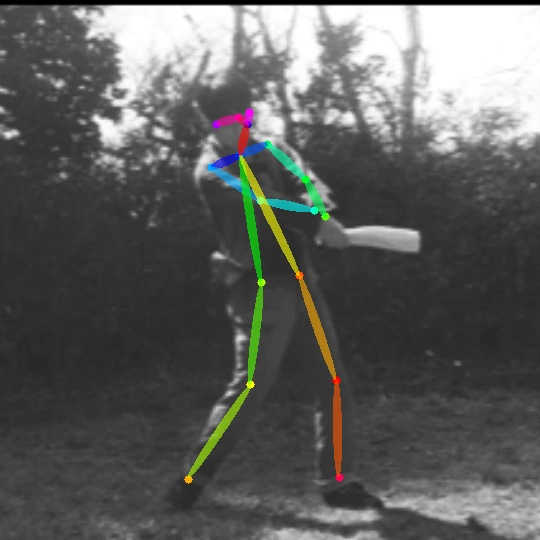

In [15]:
def print_estimation(d):
    c, s = body_estimation(d)
    # `draw_bodypose`は画像データを変更するため
    # 元データを保持したい場合はcopy.deepcopy等で複製したデータを渡す
    d = draw_bodypose(d, c, s)
    return d

# 動画の30～50フレームを5フレームごとに表示
CvCapture(sample).process_frames(frame_proc=print_estimation, target_frames=np.arange(30, 50, 5))

### 2. 動画からスイング部分を切り出す（本Notebook内では取り扱わない）

1. 姿勢推定により身体の部位の位置を取得
2. **動画からスイング部分を切り出す（本Notebook内では取り扱わない）**
3. 時系列に位置を並べてデータ化する
4. 良いパターンと良くないパターンについて学習する

スイング開始・終了の判定は条件が多く、動画全体からスイング部分のみ抜き出すコードは長くなるため割愛するが  
処理の概要は以下の通り。

* スイング先頭判定が真となるまで次のフレームを読み込む
* スイング終了判定が真となるまで部位データを取得する
* スイング先頭～終了までの代表値として11個のフレームを抽出する
* 抽出した部位データを保存する（※スイング判定完成時は、ここで保存のかわりに判定を行う）
* 動画が終了するまで上記の処理を続けて行う
* 参考：スイング先頭判定：部位データを用いる
    * 手首が近い
    * 手首の高さが頭に近い
    * 手首が一定以上の位置にある
    * 腰の左右が離れている（腰がひねられていない）
    * 全身が映っている

### 3. 時系列に位置を並べてデータ化する

1. 姿勢推定により身体の部位の位置を取得
2. 動画からスイング部分を切り出す（本Notebook内では取り扱わない）
3. **時系列に位置を並べてデータ化する**
4. 良いパターンと良くないパターンについて学習する

**スイングデータ**

スイング判定モデルの学習に使われる入力データは、部位データを時系列に並べたものとなる。  
時系列での保存は動画データのフレームを順次姿勢推定する事で行う。

そこで取得データを姿勢推定して保存する処理を定義する。（推定後に描画しているが高速化のためには描画はない方が良い。）

まず、実行短縮のためフレーム画像をデータとして保存しておく。

In [16]:
sample_frames = []

cap = CvCapture(sample)
for i in range(100):
    print('.', end='')
    frame = cap.get_specified_frame(i)
    sample_frames.append(frame)

print(len(sample_frames), 'frames')

....................................................................................................100 frames


**スイング部分の抽出**

今回はスイング開始終了を判定する箇所は作らないので、手作業で抽出フレーム番号を調整。  
以下のうちから姿勢推定が出来た11フレームのランドマークを抽出する。
* 29～40: 振りはじめ付近
* 41～52: スイング中～終了

姿勢推定が出来たかどうかはsubsetのサイズを見る。(検出できていなければ0)

In [18]:
tmp_candidates = []
tmp_subsets = []
swing_indexes = np.arange(29, 41, 5).tolist() + np.arange(41, 53, 1).tolist()
print(swing_indexes)

# 動画から指定したフレームのみ抜き出し、描画すると共にスイングデータとして収集する
# CvCapture(sample).process_frames(frame_proc=swing.collect_data, target_frames=swing_indexes)
for frame_no in swing_indexes:
    # print(frame_no, '.', end='')
    d = sample_frames[frame_no]
    c, s = body_estimation(d)
    if s.size == 0: continue
    imshow(draw_bodypose(d, c, s))
    tmp_candidates.append(c)
    tmp_subsets.append(s)

print(' collect candidates', len(tmp_candidates))

 collect candidates 15


In [19]:
# スイングのフレーム数を11に調整する
candidates = tmp_candidates[1:-3]
subsets = tmp_subsets[1:-3]

print(len(candidates))

11


**正確に検出できた部位のみ抽出する**

Candidateには18個の部位通りにデータが入っているとは限らず、余分に部位が検出されたり、見えない部分が検出できなかったりする。  
以下の例は、Candidateに20個の部位が検出されているが、そのうち2つ(ID=5,17)がSubset側に入っていない(この人物として検出できていない)。

In [20]:
print(candidates[0].shape, candidates[0])
print(subsets[0])

(20, 4) [[1.59000000e+02 1.27000000e+02 9.33841825e-01 0.00000000e+00]
 [1.92000000e+02 1.62000000e+02 8.23528647e-01 1.00000000e+00]
 [1.76000000e+02 1.63000000e+02 7.32684016e-01 2.00000000e+00]
 [1.57000000e+02 2.06000000e+02 4.58687425e-01 3.00000000e+00]
 [1.26000000e+02 1.82000000e+02 3.28317195e-01 4.00000000e+00]
 [1.60000000e+02 2.66000000e+02 1.63457826e-01 5.00000000e+00]
 [2.05000000e+02 1.61000000e+02 8.99565399e-01 6.00000000e+00]
 [1.60000000e+02 1.99000000e+02 6.98366046e-01 7.00000000e+00]
 [1.25000000e+02 1.80000000e+02 5.06687999e-01 8.00000000e+00]
 [2.02000000e+02 2.95000000e+02 8.10806155e-01 9.00000000e+00]
 [1.79000000e+02 3.92000000e+02 8.73138070e-01 1.00000000e+01]
 [1.90000000e+02 4.77000000e+02 8.45162928e-01 1.10000000e+01]
 [2.41000000e+02 2.92000000e+02 8.30851853e-01 1.20000000e+01]
 [2.65000000e+02 3.85000000e+02 8.59993637e-01 1.30000000e+01]
 [3.30000000e+02 4.78000000e+02 7.95297980e-01 1.40000000e+01]
 [1.50000000e+02 1.18000000e+02 9.10830379e-01 

In [21]:
# CandidateからSubsetに指定されているデータだけ抽出
swing_xy = []
for i, subs in enumerate(subsets):
    x = subs[0, :18].astype(int)
    swing_xy.append(candidates[i][x, :2])

swing_xy = np.array(swing_xy)
print(swing_xy.shape)
print(swing_xy[0])

(11, 18, 2)
[[159. 127.]
 [192. 162.]
 [176. 163.]
 [157. 206.]
 [126. 182.]
 [205. 161.]
 [160. 199.]
 [125. 180.]
 [202. 295.]
 [179. 392.]
 [190. 477.]
 [241. 292.]
 [265. 385.]
 [330. 478.]
 [150. 118.]
 [170. 114.]
 [138. 123.]
 [193. 111.]]


11フレーム18部位の座標データとなった。

**部位データ**

OpenPoseでは18個の部位を取得するがそのうちスイングで使用する値のみ抽出する。

In [22]:
# 部位グループ
lg_head = [0] # 鼻
lg_upper = [1, 2, 5]  # 中心、右肩、左肩
lg_arms = [3, 4, 6, 7]    # 右ひじ、右手首、左ひじ、左手首
lg_trunk = [0, 1, 8, 11]  # 鼻、中心、右腰、左腰
lg_leg = [9, 10, 12, 13]  # 右ひざ、右足首、左ひざ、左足首
# フォーム評価で用いるすべての部位
lg_all_ff = sorted(set(lg_head + lg_upper + lg_arms + lg_trunk + lg_leg))
print(lg_all_ff)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [24]:
# candidateから使う部分だけ取得する例
# 先頭フレームの14か所の座標を表示
print(swing_xy[0][lg_all_ff].shape)
swing_xy[0][lg_all_ff]

(14, 2)


array([[159., 127.],
       [192., 162.],
       [176., 163.],
       [157., 206.],
       [126., 182.],
       [205., 161.],
       [160., 199.],
       [125., 180.],
       [202., 295.],
       [179., 392.],
       [190., 477.],
       [241., 292.],
       [265., 385.],
       [330., 478.]])

**データの正規化**

ここまでに得られたスイングの部位座標は画像の左上から横方向と縦方向の位置（ピクセル数）となる。  
これには以下の問題がある。
* フレーム内における人物の位置や僅かな向きの違いにより値が変わる
* 画像サイズにより値が変わる

学習データとして使いやすくするため、今回はいくつかの処理により部位座標データを0から1の間に正規化する。  

* 人物の位置により値が変わる　⇒ピクセル数の絶対値ではなく、1フレーム目からの変化にする
* 向きや画像サイズにより値が変わる　⇒変化率を用いる

以下に計算の一部を記述する。

In [25]:
def to_train_data(data):
    # フォーム判定で使用する箇所を抽出
    s_data = copy.deepcopy(data)
    # 基準位置を0として基準位置からの移動距離に直す
    # 先頭データは基準位置(すべて0)なので除外
    s_data = s_data[1:] - s_data[0, :]
    # 移動距離を、身体の縦サイズとの移動比率に変換
    s_data = s_data / 100
    # 検出されなかった部位の値NaNを補間する
    # 間のNaNは中間値で、端のNaNは隣接値で埋める
    return s_data.reshape([s_data.shape[0], math.prod(s_data.shape[1:])])

sample_swing_td = to_train_data(swing_xy[:, lg_all_ff])
print(sample_swing_td.shape)
print(sample_swing_td)

(10, 28)
[[ 0.24 -0.02  0.2   0.03  0.18  0.03  0.26  0.14  0.56  0.93  0.26  0.03
   0.28  0.09  0.11  0.18  0.2   0.04  0.17 -0.01  0.04 -0.01  0.26  0.05
   0.38  0.1   0.11  0.09]
 [ 0.59 -0.01  0.33  0.04  0.21  0.07  0.35  0.11  0.19  0.26  0.49  0.02
   0.53  0.09  0.28  0.26  0.27  0.08  0.27 -0.02  0.07  0.05  0.43  0.06
   0.55  0.02  0.04  0.  ]
 [ 0.79  0.01  0.42  0.    0.27  0.05  0.42  0.1   0.18  0.38  0.6  -0.05
   0.65  0.02  0.32  0.36  0.31 -0.02  0.39 -0.04  0.04  0.01  0.47 -0.03
   0.58 -0.03  0.09 -0.01]
 [ 0.81 -0.03  0.49  0.02  0.25  0.13  0.38  0.26  0.5   0.63  0.73 -0.07
   0.88 -0.05  0.82  0.34  0.38 -0.01  0.49 -0.05  0.02  0.    0.53 -0.04
   0.66 -0.11  0.1  -0.08]
 [ 0.9  -0.07  0.4  -0.01  0.27  0.09  0.55  0.29  1.28  0.66  0.57 -0.08
   0.59 -0.78  0.94 -0.59  0.48 -0.05  0.65 -0.08  0.   -0.01  0.53 -0.1
   0.72 -0.01  0.08  0.  ]
 [ 0.88 -0.03  0.47 -0.07  0.35  0.04  1.03 -0.06  1.88  0.28  0.62 -0.17
   1.45 -0.2   2.    0.36  0.59 -0.13  0.71

これで1つのスイングデータ(11フレーム、14個の座標)が、機械学習用の入力データ(10フレーム、14*2=28個の変化率)となった。  
この場合、1つのスイングデータのサイズは**280**となる

### 4. 良いパターンと良くないパターンについて学習する

1. 姿勢推定により身体の部位の位置を取得
2. 動画からスイング部分を切り出す（本Notebook内では取り扱わない）
3. 時系列に位置を並べてデータ化する
4. **良いパターンと良くないパターンについて学習する**

3で正規化したスイングデータを多く用意し、そのデータからパターンを学習する。  
ここは以下の根拠から回帰分析によりスイングを学習する。

* 良いスイングと良くないスイングは一定軌道に近づく(と仮定する)
* 良いスイングと良くないスイングのパターンは異なる(と仮定する)

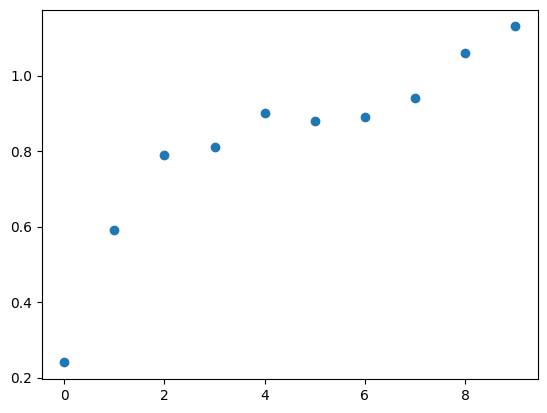

In [26]:
# 良くないと仮定したスイングのプロット(頭部分の横方向移動のみ)
d = sample_swing_td
plt.scatter(np.arange(d.shape[0]), d[:, 0])

**良いスイングパターンを求める**

上のようなフレーム毎の位置変化は、良いスイングと良くないスイングとで統計的に見て異なると考えられる。  

そこで、様々なスイングデータを集め、良い=1、良くない=0として、ラベルを付ける。  
これを1行1スイングデータとしてCSVファイルとしてまとめる。

CSVレイアウトは以下の様になる。

**列番号: 項目名**
* 0: 1フレーム目の頭x(の位置変化率)
* 1: 1フレーム目の頭y
* 2: 1フレーム目の中心x
* ...
* 279: 10フレーム目の左足首y
* 280: 良いスイングである(1または0)

In [27]:
input_data = pd.read_csv('data/train.csv', header=None)
input_data

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,0.000000,0.014925,0.000000,0.014925,0.000000,0.014925,0.014925,0.014925,0.124498,0.036145,...,0.000000,0.000000,-0.014925,0.059701,-0.014925,0.044776,0.000000,0.059701,0.000000,0
1,-0.003745,0.011236,0.007491,0.000000,0.003745,0.000000,-0.007491,-0.007491,0.124498,0.036145,...,0.011236,0.011236,0.003745,0.101124,0.007491,0.093633,-0.011236,0.089888,-0.014981,0
2,0.064257,0.012048,0.060241,0.000000,0.052209,0.016064,0.040161,-0.020080,0.124498,0.036145,...,0.008032,0.012048,0.004016,0.100402,-0.024096,0.076305,0.000000,-0.012048,-0.036145,0
3,0.081967,0.000000,0.028689,0.012295,0.012295,0.016393,0.012295,0.000000,-0.020492,-0.020492,...,0.008197,0.196721,-0.004098,0.213115,-0.020492,0.192623,0.008197,0.086066,0.000000,0
4,0.014706,-0.014706,0.000000,-0.014706,0.014706,-0.014706,0.088235,-0.009804,0.004902,-0.024510,...,0.004902,-0.058824,0.053922,-0.039216,-0.034314,-0.068627,-0.039216,-0.014706,-0.009804,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,-0.014151,-0.004717,0.014151,0.018868,0.018868,0.023585,0.037736,0.009434,0.033019,0.004717,...,0.018868,-0.042453,0.028302,0.216981,0.042453,0.330189,-0.014151,0.231132,0.042453,0
749,0.061453,-0.022346,0.055866,0.011173,0.027933,0.005587,0.094972,0.083799,0.022346,0.067039,...,0.005587,-0.050279,-0.005587,0.044693,-0.044693,0.027933,-0.016760,-0.011173,0.005587,0
750,0.039106,0.000000,0.022346,0.005587,0.039106,0.016760,0.072626,0.050279,0.016760,-0.005587,...,0.027933,-0.050279,0.005587,0.122905,-0.027933,0.111732,0.011173,0.011173,-0.005587,0
751,0.032787,-0.021858,0.032787,0.005464,0.016393,0.005464,0.010929,-0.005464,-0.005464,-0.005464,...,-0.010929,0.000000,-0.005464,0.158470,-0.016393,0.169399,0.005464,0.021858,0.000000,0


281列目に0または1があり、これがその行のスイングが良いか悪いかのラベルとなる。
以下の通り、良いスイングのデータも含まれている。

In [28]:
input_data.loc[input_data[280] == 1]

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
365,-0.009662,0.009662,0.000000,-0.009662,0.000000,0.000000,0.028986,0.033816,0.019324,0.024155,...,0.053140,0.004831,-0.043478,0.004831,0.000000,0.014493,-0.004831,0.000000,0.009662,1
366,0.000000,0.000000,0.000000,0.002976,0.000000,0.000000,0.000000,0.002976,-0.002976,0.000000,...,0.026786,0.000000,-0.014881,-0.005952,-0.011905,0.000000,-0.002976,0.002976,0.000000,1
367,0.019380,0.062016,0.019380,0.042636,0.034884,0.042636,0.100775,-0.019380,0.151163,0.034884,...,0.058140,-0.108527,-0.054264,-0.228682,0.023256,-0.174419,0.062016,-0.197674,0.058140,1
368,0.100437,-0.008734,0.078603,0.026201,0.074236,0.048035,0.034934,0.000000,0.139738,0.000000,...,0.078603,-0.082969,-0.061135,-0.082969,-0.021834,-0.078603,-0.078603,-0.170306,-0.008734,1
369,-0.011628,-0.011628,0.011628,0.000000,0.023256,0.011628,0.186047,0.046512,0.011628,-0.011628,...,0.011628,-0.034884,-0.023256,-0.093023,-0.023256,-0.127907,0.011628,-0.081395,-0.023256,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.033613,0.016807,0.025210,0.025210,0.033613,0.016807,0.025210,0.008403,0.042017,0.008403,...,0.092437,0.050420,-0.050420,0.302521,-0.008403,0.369748,0.000000,0.336134,0.050420,1
648,0.038462,0.009615,0.028846,0.000000,0.019231,0.000000,0.009615,0.000000,0.028846,0.009615,...,0.048077,0.076923,-0.086538,0.182692,0.019231,0.365385,0.105769,0.201923,0.105769,1
649,0.009615,0.000000,0.000000,0.009615,0.000000,0.000000,0.009615,0.000000,0.019231,0.009615,...,0.048077,0.057692,-0.076923,0.211538,0.019231,0.384615,0.115385,0.269231,0.134615,1
650,0.009709,0.000000,0.009709,0.000000,0.009709,0.000000,0.009709,-0.009709,0.000000,0.000000,...,0.038835,0.058252,-0.077670,0.145631,0.000000,0.262136,0.048544,0.126214,0.097087,1


参考：OpenPose部位

~~~
０：頭(鼻)、１：中心(心臓付近)、２：右肩、3：右肘、４：右手首、５：左肩、６：左肘
７：左手首、８：右腰、９：右膝、10：右足首、11：左腰、12：左膝、13：左足首
14：右目、15：左目、16：右耳、17：左耳
~~~

試しにXGBoostによる回帰を行う

In [29]:
import xgboost

print(xgboost.__version__)
model = xgboost.XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

print(input_data.shape)
x, y = input_data.values[:, :-1], input_data.values[:, -1]
model.fit(x, y)

1.7.3
(753, 281)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

先ほどの自分のスイングデータ(学習CSVデータに含まれていない)を判定してみる

In [30]:
d = sample_swing_td.astype(float)
print(d.shape)
d = d.reshape(1, 280)
print(d.shape)
model.predict(d)

(10, 28)
(1, 280)


array([0.46970952], dtype=float32)

値は0から1の値を取る。  
これを「良いスイング」である確度と考えると、例えば、0.5以上であれば良いスイングと判定する事になる。